### 🛰️위성 이미지 분류

In [1]:
# 데이터셋 로드
import tensorflow as tf
import numpy as np
import json
import matplotlib.pyplot as plt

# Tensorflow dataset
import tensorflow_datasets as tfds

In [2]:
# EuroSAT 위성 사진 데이터셋 로드
DATA_DIR = 'dataset/'
(train_ds, valid_ds), info = tfds.load('eurosat/rgb', split=['train[:80%]', 'train[80%:]'],
                                      shuffle_files=True,
                                       # 튜플형식으로 return
                                      as_supervised=True,
                                      with_info=True,
                                      data_dir=DATA_DIR)

In [3]:
print(train_ds)
print(valid_ds)

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


In [4]:
print(info)

tfds.core.DatasetInfo(
    name='eurosat',
    full_name='eurosat/rgb/2.0.0',
    description="""
    EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral
    bands and consisting of 10 classes with 27000 labeled and
    geo-referenced samples.
    
    Two datasets are offered:
    - rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image.
    - all: Contains all 13 bands in the original value range (float32).
    
    URL: https://github.com/phelber/eurosat
    """,
    config_description="""
    Sentinel-2 RGB channels
    """,
    homepage='https://github.com/phelber/eurosat',
    data_path='dataset/eurosat\\rgb\\2.0.0',
    file_format=tfrecord,
    download_size=89.91 MiB,
    dataset_size=89.50 MiB,
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=string),
        'image': Image(shape=(64, 64, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image',

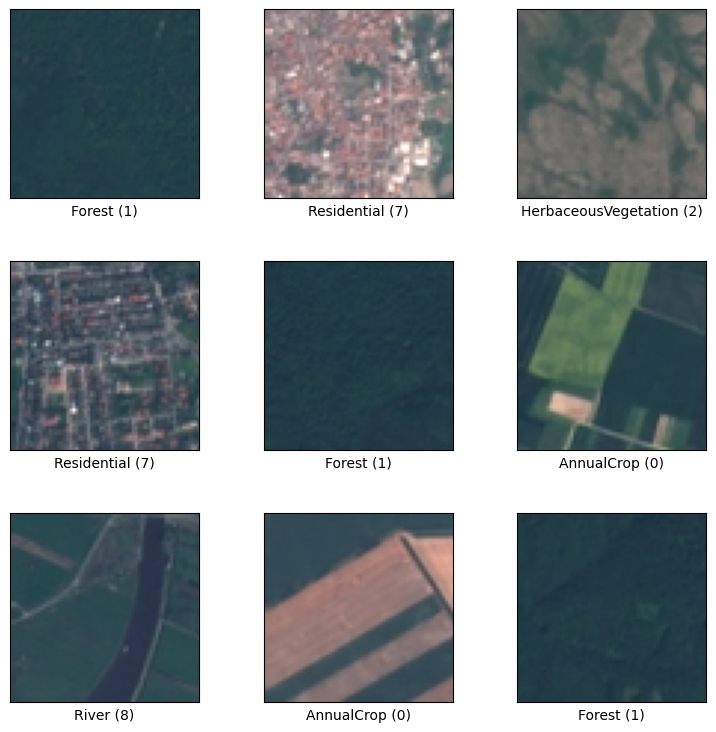

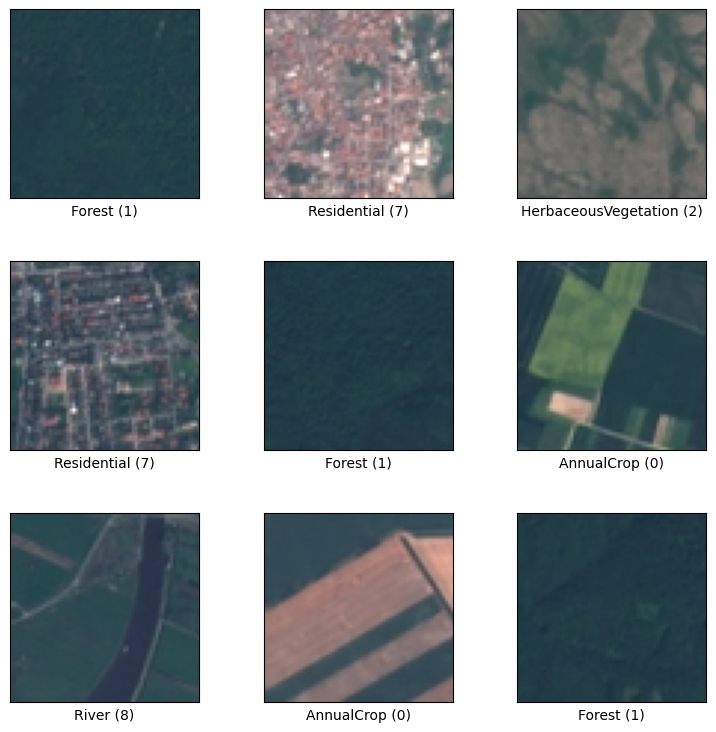

In [5]:
# 데이터확인
tfds.show_examples(train_ds, info)

,image,label
0,,5 (Pasture)
1,,7 (Residential)
2,,0 (AnnualCrop)
3,,1 (Forest)
4,,0 (AnnualCrop)
5,,2 (HerbaceousVegetation)
6,,9 (SeaLake)
7,,8 (River)
8,,2 (HerbaceousVegetation)
9,,9 (SeaLake)

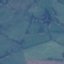
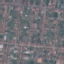
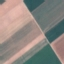
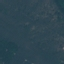
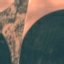
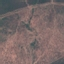
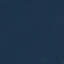
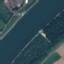
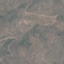
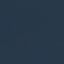

In [6]:
# as_dataframe 함수 사용
tfds.as_dataframe(valid_ds.take(10), info)

In [7]:
# 목표 클래스의 개수
NUM_CLASSES = info.features['label'].num_classes
print(NUM_CLASSES)

10


In [8]:
info.features['label'].int2str(6)

'PermanentCrop'

In [9]:
# 데이터 전처리
BATCH_SIZE = 64

# buffer_size만큼 data를 채우고 random sampling하여 새로운 data로 바꿈
BUFFER_SIZE = 1000

def preprocess_data(image, label):
    image = tf.cast(image, tf.float32) / 255.   # 0 ~ 1 정규화
    return image, label

In [10]:
train_data = train_ds.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
valid_data = valid_ds.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)

train_data = train_data.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_data = valid_data.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

In [11]:
print(train_data)
print(valid_data)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [12]:
# 모델 훈련 및 검증
def build_model():
    model = tf.keras.Sequential([
        # tf.keras.layers.Input(shape=(64, 64, 3)),
        # Convolution Layer
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        # Classifier Output Layer
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax'),
    ])
    
    return model

In [13]:
model = build_model()

In [14]:
model.compile(optimizer='adam',
             metrics=['acc'],
             loss='sparse_categorical_crossentropy')

In [15]:
history = model.fit(train_data,
                    validation_data=valid_data,
                   epochs=50)

Epoch 1/50
338/338 [==============================] - 51s 147ms/step - loss: 1.6397 - acc: 0.4389 - val_loss: 1.4563 - val_acc: 0.5339
Epoch 2/50
338/338 [==============================] - 59s 175ms/step - loss: 1.2559 - acc: 0.5536 - val_loss: 0.8697 - val_acc: 0.7002
Epoch 3/50
338/338 [==============================] - 82s 244ms/step - loss: 1.0476 - acc: 0.6268 - val_loss: 0.7551 - val_acc: 0.7596
Epoch 4/50
338/338 [==============================] - 77s 227ms/step - loss: 0.9322 - acc: 0.6714 - val_loss: 0.6654 - val_acc: 0.7870
Epoch 5/50
338/338 [==============================] - 83s 244ms/step - loss: 0.8672 - acc: 0.6993 - val_loss: 0.6413 - val_acc: 0.7904
Epoch 6/50
338/338 [==============================] - 87s 257ms/step - loss: 0.7811 - acc: 0.7290 - val_loss: 0.5782 - val_acc: 0.8111
Epoch 7/50
338/338 [==============================] - 74s 219ms/step - loss: 0.7335 - acc: 0.7507 - val_loss: 0.5854 - val_acc: 0.8152
Epoch 8/50
338/338 [==============================] - 8

In [16]:
import pandas as pd
history_df = pd.DataFrame(history.history)

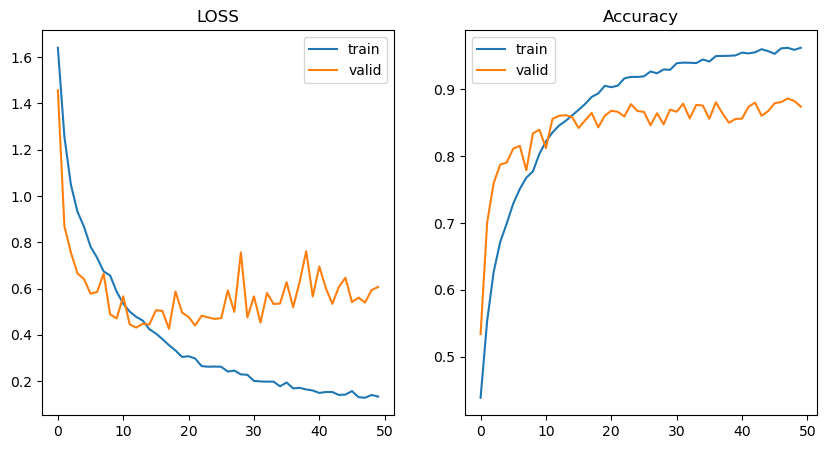

In [17]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history_df.loss)
plt.plot(history_df.val_loss)
plt.legend(['train', 'valid'])
plt.title('LOSS')

plt.subplot(1, 2, 2)
plt.plot(history_df.acc)
plt.plot(history_df.val_acc)
plt.legend(['train', 'valid'])
plt.title('Accuracy')
plt.show()

✔️train보다 valid의 loss가 더 높고 accuracy가 낮으므로 `과대적합`이라 할 수 있다.

In [18]:
# 데이터 증강
# sample image
image_batch, label_batch = next(iter(train_data.take(1)))

In [19]:
image = image_batch[2]
label = label_batch[2].numpy()

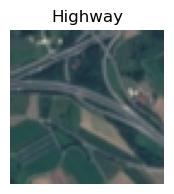

In [20]:
plt.figure(figsize=(2, 2))
plt.imshow(image)
plt.title(info.features['label'].int2str(label))
plt.axis('off')
plt.show()

In [21]:
# 데이터 증강 전후 비교하는 시각화 함수
def plot_augmentation(original, augmented):
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    
    axes[0].imshow(original)
    axes[0].set_title('Original')
    
    axes[1].imshow(augmented)
    axes[1].set_title('Augmented')
    
    plt.show()

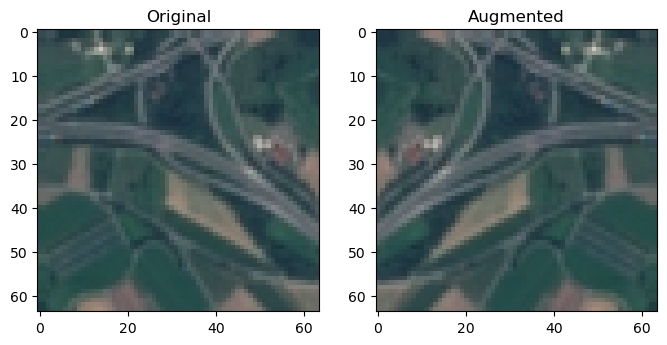

In [22]:
# flip_left_right : 이미지를 좌우 방향으로 뒤집기
lr_flip = tf.image.flip_left_right(image)
plot_augmentation(image, lr_flip)

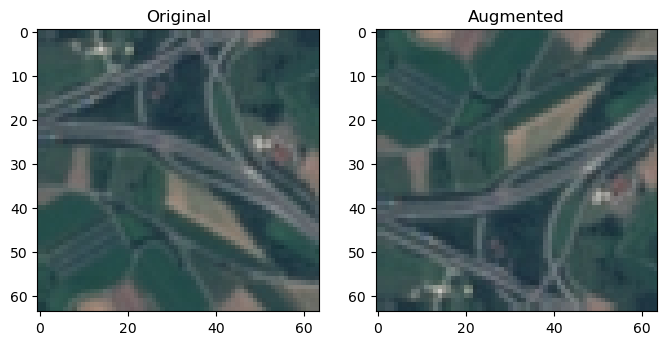

In [23]:
# flip_up_down : 이미지를 상하 방향으로 뒤집는 방법
uf_flip = tf.image.flip_up_down(image)
plot_augmentation(image, uf_flip)

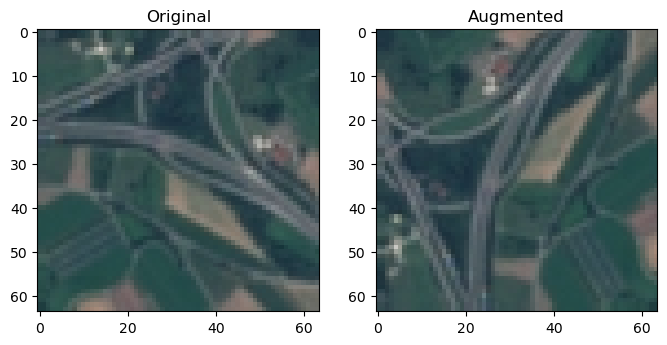

In [24]:
# rot90 : 이미지를 반시계 방향으로 90도 회전
rotate90 = tf.image.rot90(image)
plot_augmentation(image, rotate90)

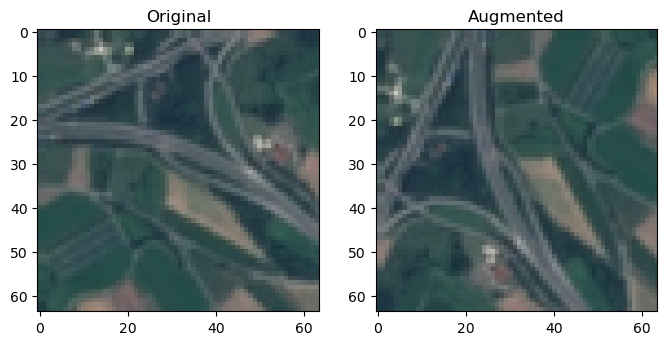

In [25]:
# transpose : 이미지 텐서 행렬의 행과 열의 위치를 바꿔줌
transpose = tf.image.transpose(image)
plot_augmentation(image, transpose)

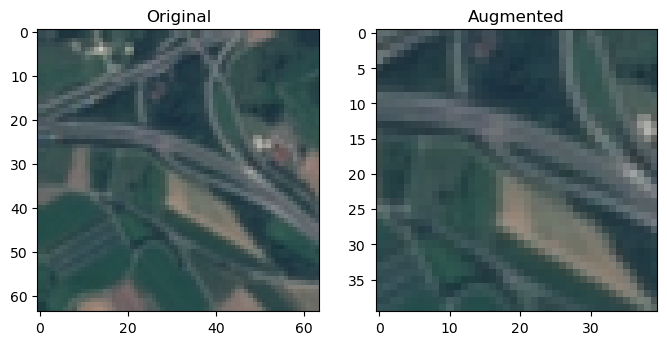

In [26]:
# central_crop : 이미지의 중심에서 일정 부분을 잘라냄
crop1 = tf.image.central_crop(image, central_fraction=0.6)
plot_augmentation(image, crop1)

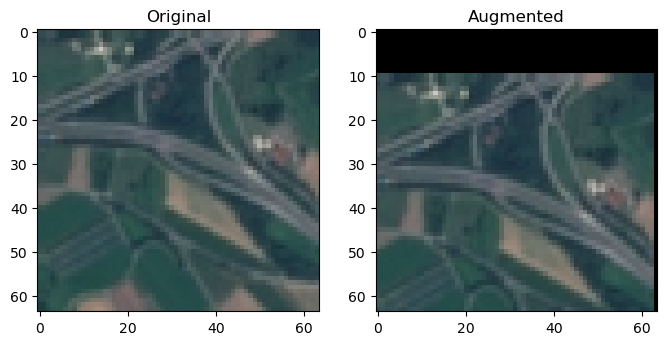

In [27]:
# resize_with_crop_or_pad : 이미지 크기 키우기
# random_crop : 이미지의 원본 크기와 같게 자름 => 상하좌우 랜덤한 방향으로 shift
img = tf.image.resize_with_crop_or_pad(image, 64 + 20, 64 + 20)
crop2 = tf.image.random_crop(img, size=[64, 64, 3])
plot_augmentation(image, crop2)

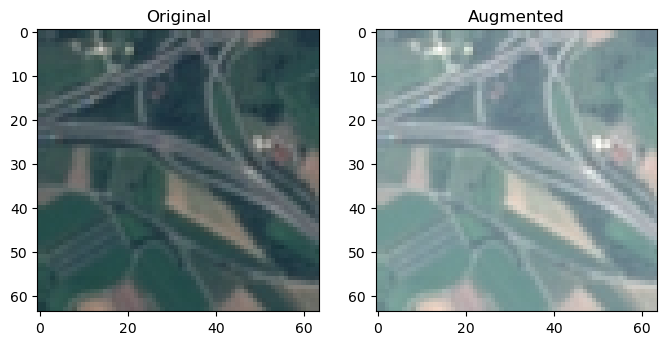

In [28]:
# 이미지 밝기
brightness = tf.image.adjust_brightness(image, delta=0.3)
plot_augmentation(image, brightness)

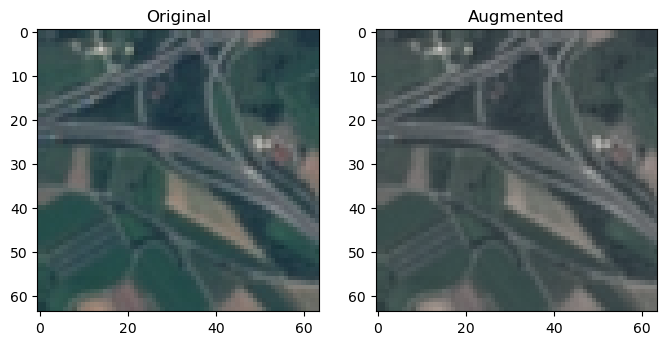

In [29]:
# 이미지 채도
saturation = tf.image.adjust_saturation(image, saturation_factor=0.5)
plot_augmentation(image, saturation)

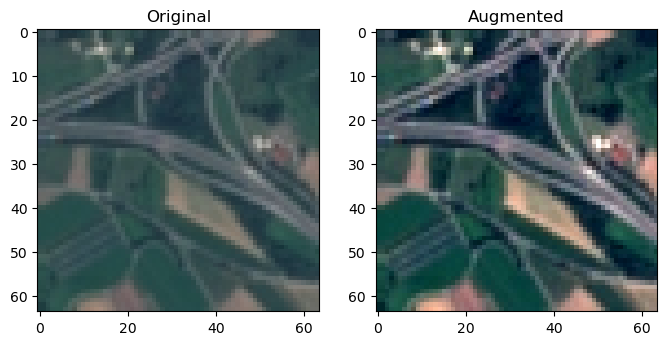

In [30]:
# 이미지 대비
contrast = tf.image.adjust_contrast(image, contrast_factor=2)
plot_augmentation(image, contrast)

In [31]:
# 이미지 증강 전처리
def data_augmentation(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.3)
    image = tf.image.random_crop(image, size=[64, 64, 3])
    
    image = tf.cast(image, tf.float32) / 255.
    
    return image, label

In [32]:
train_aug = train_ds.map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)
valid_aug = valid_ds.map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)

train_aug = train_aug.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_aug = valid_aug.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

In [33]:
print(train_aug)
print(valid_aug)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [34]:
# Create model
aug_model = build_model()

In [35]:
# Compile model
aug_model.compile(optimizer='adam',
                 metrics=['acc'],
                 loss='sparse_categorical_crossentropy')

In [36]:
# Training model
history = aug_model.fit(train_aug,
             validation_data=valid_aug,
             epochs=20)

Epoch 1/20
338/338 [==============================] - 97s 281ms/step - loss: 1.9210 - acc: 0.2878 - val_loss: 1.8528 - val_acc: 0.3044
Epoch 2/20
338/338 [==============================] - 85s 252ms/step - loss: 1.6111 - acc: 0.3744 - val_loss: 1.4443 - val_acc: 0.4417
Epoch 3/20
338/338 [==============================] - 99s 294ms/step - loss: 1.4807 - acc: 0.4245 - val_loss: 1.2446 - val_acc: 0.5122
Epoch 4/20
338/338 [==============================] - 85s 250ms/step - loss: 1.3750 - acc: 0.4672 - val_loss: 1.1835 - val_acc: 0.5719
Epoch 5/20
338/338 [==============================] - 86s 252ms/step - loss: 1.3021 - acc: 0.5042 - val_loss: 1.0891 - val_acc: 0.6269
Epoch 6/20
338/338 [==============================] - 99s 291ms/step - loss: 1.2187 - acc: 0.5404 - val_loss: 0.9985 - val_acc: 0.6407
Epoch 7/20
338/338 [==============================] - 91s 267ms/step - loss: 1.1669 - acc: 0.5701 - val_loss: 0.9557 - val_acc: 0.6539
Epoch 8/20
338/338 [==============================] - 8

In [37]:
history_df = pd.DataFrame(history.history)
history_df

,loss,acc,val_loss,val_acc
0,1.920967,0.287824,1.852784,0.304444
1,1.611074,0.374398,1.444340,0.441667
2,1.480692,0.424537,1.244630,0.512222
3,1.374986,0.467176,1.183469,0.571852
4,1.302085,0.504167,1.089134,0.626852
5,1.218717,0.540417,0.998487,0.640741
6,1.166904,0.570093,0.955719,0.653889
7,1.122286,0.586759,0.894622,0.697037
8,1.058035,0.611944,0.856917,0.702407
9,1.015610,0.631250,0.928376,0.692222


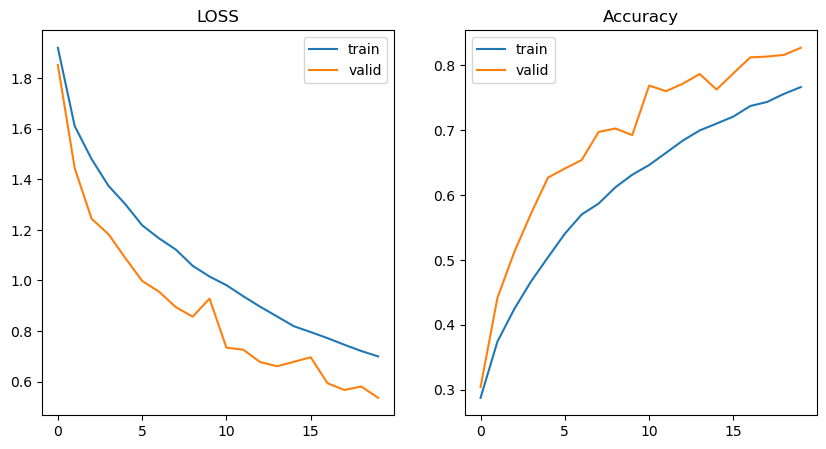

In [38]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history_df.loss)
plt.plot(history_df.val_loss)
plt.legend(['train', 'valid'])
plt.title('LOSS')

plt.subplot(1, 2, 2)
plt.plot(history_df.acc)
plt.plot(history_df.val_acc)
plt.legend(['train', 'valid'])
plt.title('Accuracy')
plt.show()

In [39]:
# ResNet 사전 학습 모델
from tensorflow.keras.applications import ResNet50V2

![ResNet](https://www.researchgate.net/publication/344341113/figure/fig3/AS:938601894387715@1600791538743/Architectures-of-the-best-fine-tuning-models-namely-VGG16-ResNet50V2-and-DenseNet169.png)

In [40]:
pre_trained_base = ResNet50V2(
    # 기존 ResNet 모델의 Top층 제거
    include_top=False,
    weights='imagenet',
    input_shape=[64, 64, 3])

In [41]:
# 사전 학습된 가중치 업데이트 X
pre_trained_base.trainable = False

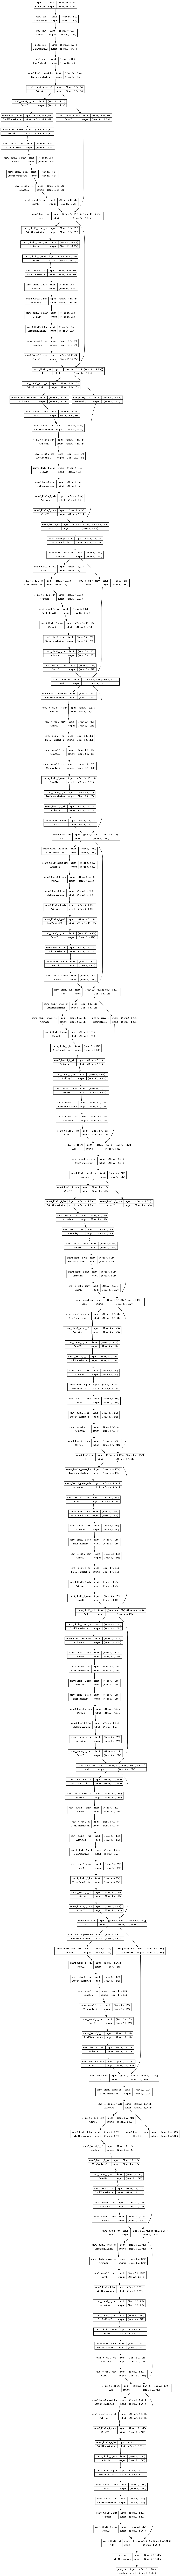

In [42]:
# 모델 구조 시각화
from tensorflow.keras.utils import plot_model
plot_model(pre_trained_base, show_shapes=True, show_layer_names=True)

In [43]:
# Top 층에 Classifier 추가
def build_trainsfer_classifier():
    model = tf.keras.Sequential([
        pre_trained_base,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    
    return model

In [44]:
tc_model = build_trainsfer_classifier()

In [45]:
tc_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2, 2, 2048)        23564800  
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dense_6 (Dense)             (None, 128)               1048704   
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 10)               

In [46]:
tc_model.compile(optimizer='adam',
                metrics=['acc'],
                loss='sparse_categorical_crossentropy')

In [47]:
tc_history = tc_model.fit(train_aug,
                         validation_data=valid_aug,
                         epochs=20)

Epoch 1/20
338/338 [==============================] - 157s 456ms/step - loss: 1.0135 - acc: 0.6731 - val_loss: 0.5878 - val_acc: 0.8030
Epoch 2/20
338/338 [==============================] - 157s 463ms/step - loss: 0.7233 - acc: 0.7686 - val_loss: 0.5315 - val_acc: 0.8231
Epoch 3/20
338/338 [==============================] - 165s 486ms/step - loss: 0.6472 - acc: 0.7904 - val_loss: 0.4937 - val_acc: 0.8357
Epoch 4/20
338/338 [==============================] - 158s 465ms/step - loss: 0.5864 - acc: 0.8090 - val_loss: 0.4851 - val_acc: 0.8331
Epoch 5/20
338/338 [==============================] - 157s 464ms/step - loss: 0.5667 - acc: 0.8172 - val_loss: 0.4629 - val_acc: 0.8431
Epoch 6/20
338/338 [==============================] - 159s 471ms/step - loss: 0.5332 - acc: 0.8245 - val_loss: 0.4582 - val_acc: 0.8483
Epoch 7/20
338/338 [==============================] - 154s 453ms/step - loss: 0.5155 - acc: 0.8346 - val_loss: 0.4551 - val_acc: 0.8476
Epoch 8/20
338/338 [============================

In [50]:
tc_df = pd.DataFrame(tc_history.history)
tc_df

,loss,acc,val_loss,val_acc
0,1.013527,0.673148,0.587832,0.802963
1,0.723296,0.768565,0.531478,0.823148
2,0.647203,0.790370,0.493740,0.835741
3,0.586436,0.808981,0.485108,0.833148
4,0.566731,0.817222,0.462922,0.843148
5,0.533215,0.824537,0.458159,0.848333
6,0.515459,0.834583,0.455075,0.847593
7,0.506345,0.833843,0.437065,0.852222
8,0.488781,0.840231,0.435346,0.855000
9,0.477508,0.840926,0.445737,0.846852


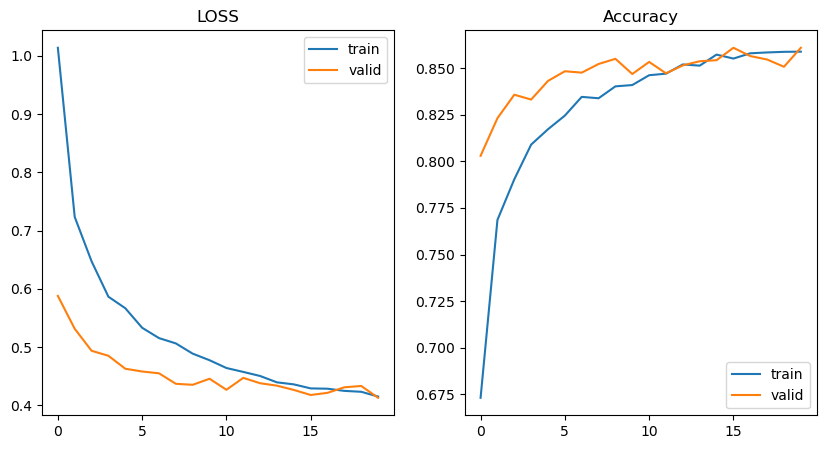

In [51]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(tc_df.loss)
plt.plot(tc_df.val_loss)
plt.legend(['train', 'valid'])
plt.title('LOSS')

plt.subplot(1, 2, 2)
plt.plot(tc_df.acc)
plt.plot(tc_df.val_acc)
plt.legend(['train', 'valid'])
plt.title('Accuracy')
plt.show()